# Tutorial 3: Running Quantization-Aware Training (QAT) on Bert

In this tutorial, we'll build on top of Tutorial 2 by taking the Bert model fine tuned for sequence classification and running Mase's quantization pass. First, we'll run simple Post-Training Quantization (PTQ) and see how much accuracy drops. Then, we'll run some further training iterations of the quantized model (i.e. QAT) and see whether the accuracy of the trained quantized model approaches the accuracy of the original (full-precision) model.

In [1]:
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

## Importing the model

If you are starting from scratch, you can create a MaseGraph for Bert by running the following cell.

In [2]:
from transformers import AutoModelForSequenceClassification

from chop import MaseGraph
import chop.passes as passes

model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
model.config.problem_type = "single_label_classification"

mg = MaseGraph(
    model,
    hf_input_names=[
        "input_ids",
        "attention_mask",
        "labels",
    ],
)

mg, _ = passes.init_metadata_analysis_pass(mg)
mg, _ = passes.add_common_metadata_analysis_pass(mg)

/home/neil/adls/adls_group_14/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/neil/adls/adls_group_14/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
`past_key_values` were not specified as input names, but model.config.use_cache = True. Setti

tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

If you have previously ran the tutorial on LoRA Finetuning, run the following cell to import the fine tuned checkpoint.

In [3]:
from pathlib import Path
from chop import MaseGraph

mg = MaseGraph.from_checkpoint(f"{Path.home()}/tutorial_2_lora")

WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.


## Post-Training Quantization (PTQ)

Here, we simply quantize the model and evaluate the effect in its accuracy. First, let's evaluate the model accuracy before quantization (if you're coming from Tutorial 2, this should be the same as the post-LoRA evaluation accuracy). As seen in Tutorial 2, we can use the `get_tokenized_dataset` and `get_trainer` utilities to generate a HuggingFace `Trainer` instance for training and evaluation.

In [4]:
from chop.tools import get_tokenized_dataset, get_trainer

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
)

# Evaluate accuracy
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
Map: 100%|██████████| 50000/50000 [00:11<00:00, 4184.19 examples/s]
/home/neil/adls/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.83244


To run the quantization pass, we pass a quantization configuration dictionary as argument. This defines the quantization mode, numerical format and precision for each operator in the graph. We'll run the quantization in "by type" mode, meaning nodes are quantized according to their `mase_op`. Other modes include by name and by regex name. We'll quantize all activations, weights and biases in the model to fixed-point with the same precision. This may be sub-optimal, but works as an example. In future tutorials, we'll see how to run the `search` flow in `Mase` to find optimal quantization configurations to minimize accuracy loss.

In [5]:
import chop.passes as passes

quantization_config = {
    "by": "type",
    "default": {
        "config": {
            "name": None,
        }
    },
    "linear": {
        "config": {
            "name": "integer",
            # data
            "data_in_width": 8,
            "data_in_frac_width": 4,
            # weight
            "weight_width": 8,
            "weight_frac_width": 4,
            # bias
            "bias_width": 8,
            "bias_frac_width": 4,
        }
    },
}

mg, _ = passes.quantize_transform_pass(
    mg,
    pass_args=quantization_config,
)

Let's evaluate the immediate effect of quantization on the model accuracy.

In [6]:
trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
)
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

/home/neil/adls/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.80492


We can save the current checkpoint for future reference (optional).

In [7]:
from pathlib import Path

mg.export(f"{Path.home()}/tutorial_3_ptq")

INFO     Exporting MaseGraph to /home/neil/tutorial_3_ptq.pt, /home/neil/tutorial_3_ptq.mz
INFO     Exporting GraphModule to /home/neil/tutorial_3_ptq.pt
INFO     Saving full model format
INFO     Exporting MaseMetadata to /home/neil/tutorial_3_ptq.mz


## Quantization-Aware Training (QAT)

You should have seen in the last section that quantization can lead to a significant drop in accuracy. Next, we'll run QAT to evaluate whether this performance gap can be reduced. To run QAT in Mase, all you need to do is include the model back in your training loop after running the quantization pass.

In [8]:
# Evaluate accuracy
trainer.train()
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

Step,Training Loss
500,0.424500
1000,0.405100
1500,0.414700
2000,0.387500
2500,0.397700
3000,0.396000


Evaluation accuracy: 0.838


We can see the accuracy of the quantized model can match (or sometimes exceed) the full precision model, with a much lower memory requirement to store the weights. Finally, save the final checkpoint for future tutorials.

In [9]:
from pathlib import Path

mg.export(f"{Path.home()}/tutorial_3_qat")

INFO     Exporting MaseGraph to /home/neil/tutorial_3_qat.pt, /home/neil/tutorial_3_qat.mz
INFO     Exporting GraphModule to /home/neil/tutorial_3_qat.pt
INFO     Saving full model format
INFO     Exporting MaseMetadata to /home/neil/tutorial_3_qat.mz


## Exploring Precision vs. Accuracy

In Tutorial 3, we quantized every Linear layer in the model to a fixed configuration. Now, we explore a range of fixed point widths from 4 to 32 to see their effect on accuracy. We will plot separate curves for PTQ and QAT at each precision to show the effect of post-quantization finetuning.

--- Evaluating bit width: 4 ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

/home/neil/adls/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  Evaluating PTQ accuracy...


  PTQ Accuracy for 4 bits: 0.5000
  Running QAT training...


Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100


  QAT Accuracy for 4 bits: 0.5000
--- Evaluating bit width: 8 ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

/home/neil/adls/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  PTQ Accuracy for 8 bits: 0.5000
  Running QAT training...


Step,Training Loss
500,0.644000
1000,0.483300
1500,0.426500
2000,0.383700
2500,0.371300
3000,0.373300


  QAT Accuracy for 8 bits: 0.8571
--- Evaluating bit width: 12 ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

/home/neil/adls/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  PTQ Accuracy for 12 bits: 0.4342
  Running QAT training...


Step,Training Loss
500,0.629200
1000,0.443100
1500,0.412800
2000,0.372700
2500,0.363600
3000,0.368300


  QAT Accuracy for 12 bits: 0.8578
--- Evaluating bit width: 16 ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

/home/neil/adls/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  PTQ Accuracy for 16 bits: 0.4768
  Running QAT training...


Step,Training Loss
500,0.631300
1000,0.446100
1500,0.411000
2000,0.368800
2500,0.355600
3000,0.368400


  QAT Accuracy for 16 bits: 0.8586
--- Evaluating bit width: 24 ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

/home/neil/adls/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  PTQ Accuracy for 24 bits: 0.4669
  Running QAT training...


Step,Training Loss
500,0.632700
1000,0.444700
1500,0.409700
2000,0.367100
2500,0.358500
3000,0.369300


  QAT Accuracy for 24 bits: 0.8589
--- Evaluating bit width: 32 ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

/home/neil/adls/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  PTQ Accuracy for 32 bits: 0.4675
  Running QAT training...


Step,Training Loss
500,0.628700
1000,0.439300
1500,0.408600
2000,0.365300
2500,0.356600
3000,0.367400


  QAT Accuracy for 32 bits: 0.8597


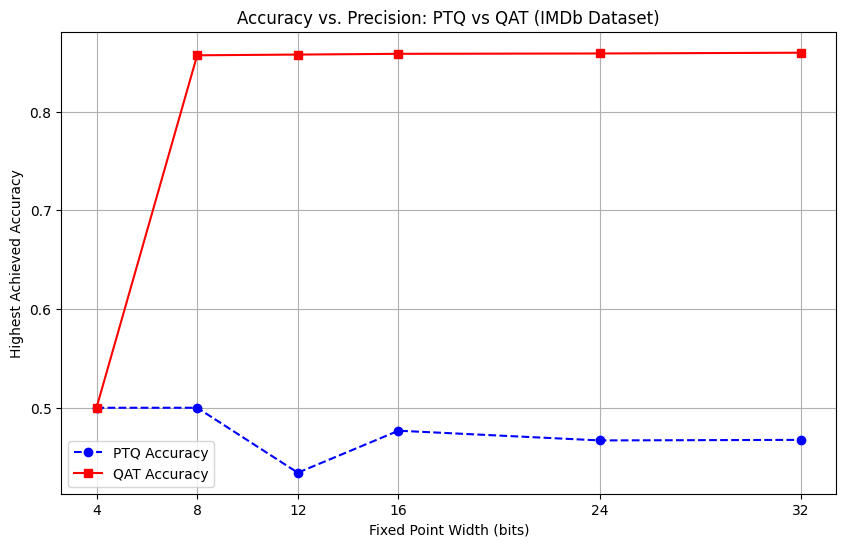

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from chop.ir.graph.mase_graph import MaseGraph
import chop.passes as passes
from chop.tools import get_trainer
from transformers import AutoModelForSequenceClassification

# Define bit widths to explore
bit_widths = [4, 8, 12, 16, 24, 32]
ptq_accuracies = []
qat_accuracies = []

for width in bit_widths:
    print(f"--- Evaluating bit width: {width} ---")
    # For simplicity, we use half of the bit-width for the fractional part
    frac_width = width // 2
    
    # Initialize a fresh model and MaseGraph for each bit-width
    model_fp = AutoModelForSequenceClassification.from_pretrained(checkpoint)
    model_fp.config.problem_type = "single_label_classification"
    
    mg_loop = MaseGraph(
        model_fp,
        hf_input_names=["input_ids", "attention_mask", "labels"],
    )
    mg_loop, _ = passes.init_metadata_analysis_pass(mg_loop)
    mg_loop, _ = passes.add_common_metadata_analysis_pass(mg_loop)
    
    quantization_config = {
        "by": "type",
        "default": {"config": {"name": None}},
        "linear": {
            "config": {
                "name": "integer",
                "data_in_width": width, 
                "data_in_frac_width": frac_width,
                "weight_width": width, 
                "weight_frac_width": frac_width,
                "bias_width": width, 
                "bias_frac_width": frac_width,
            }
        },
    }
    
    # Apply PTQ
    mg_loop, _ = passes.quantize_transform_pass(mg_loop, pass_args=quantization_config)
    
    trainer_loop = get_trainer(
        model=mg_loop.model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
    )
    
    print(f"  Evaluating PTQ accuracy...")
    ptq_res = trainer_loop.evaluate()
    ptq_acc = ptq_res["eval_accuracy"]
    ptq_accuracies.append(ptq_acc)
    print(f"  PTQ Accuracy for {width} bits: {ptq_acc:.4f}")
    
    # Apply QAT (Fine-tuning)
    print(f"  Running QAT training...")
    trainer_loop.train()
    qat_res = trainer_loop.evaluate()
    qat_acc = qat_res["eval_accuracy"]
    qat_accuracies.append(qat_acc)
    print(f"  QAT Accuracy for {width} bits: {qat_acc:.4f}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(bit_widths, ptq_accuracies, label='PTQ Accuracy', marker='o', linestyle='--', color='blue')
plt.plot(bit_widths, qat_accuracies, label='QAT Accuracy', marker='s', linestyle='-', color='red')
plt.xlabel('Fixed Point Width (bits)')
plt.ylabel('Highest Achieved Accuracy')
plt.title('Accuracy vs. Precision: PTQ vs QAT (IMDb Dataset)')
plt.legend()
plt.grid(True)
plt.xticks(bit_widths)
plt.show()

In [11]:
print(f'bit_widths = {bit_widths} \nptq_accuracies = {ptq_accuracies}\nqat_accuracies = {qat_accuracies}')


bit_widths = [4, 8, 12, 16, 24, 32] 
ptq_accuracies = [0.5, 0.5, 0.4342, 0.47676, 0.46692, 0.46748]
qat_accuracies = [0.5, 0.85708, 0.8578, 0.85856, 0.85892, 0.85968]


In [ ]:
print(f'''bit_widths = {bit_widths} \n
      ptq_accuracies = {ptq_accuracies}\n
      qat_accuracies = {qat_accuracies}''')